In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import numpy as np
from utils import * 
from training_utils import *
from ray.tune import ExperimentAnalysis

In [10]:
img_size = 224

root_dir = '../DL_project/hoop_training_imgs'
temp_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=root_dir, transform = temp_transforms)
# check class balance
class_names = dataset.classes

class_count = {}
for i in range(len(class_names)):
    class_count[class_names[i]] = 0
for img, label in dataset:
    class_count[class_names[label]] += 1
print(class_count)
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height, and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    # Var(X) = E[X^2] - E[X]^2
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(DataLoader(dataset, batch_size=128, shuffle=True, num_workers = 4))
print(f"Mean: {mean}")
print(f"Std: {std}")

{'0': 4361, '1': 2146}
Mean: tensor([0.5775, 0.5072, 0.4553])
Std: tensor([0.2236, 0.2230, 0.2123])


In [13]:
dataset = datasets.ImageFolder(root=root_dir, transform = temp_transforms)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to 224x224
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly changes brightness, contrast, and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean=mean, std=std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean=mean, std=std),
])

batch_size = 64


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)






# train_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/train', transform=train_transforms)
# valid_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/val', transform=val_test_transforms)
# test_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/test', transform=val_test_transforms)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


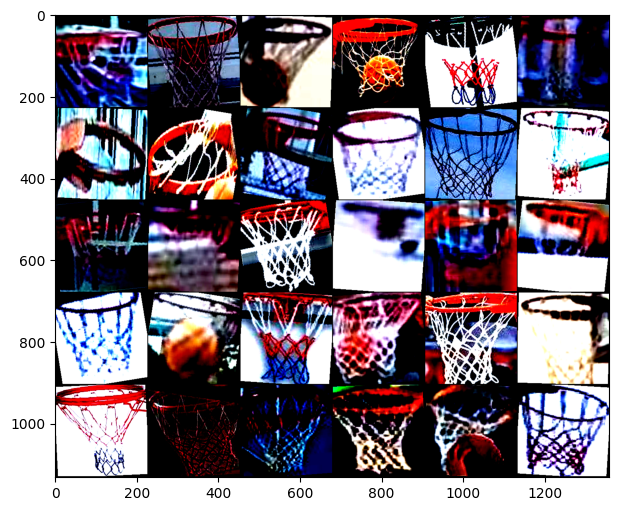

In [14]:
def imshow(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def visualize_transform(train_transforms = train_transforms, root_dir = None, subset_size = 30 ):
    subset_dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)

    # Select 30 random images from the subset
    subset_size = 30  # Number of images to display
    subset_indices = torch.randperm(len(subset_dataset))[:subset_size]

    # Using Subset to create a smaller dataset
    visualize_subset = torch.utils.data.Subset(subset_dataset, subset_indices)

    # DataLoader for the subset
    visualize_loader = DataLoader(visualize_subset, batch_size=subset_size, shuffle=False)

    # Retrieve the images from the loader
    images_transformed, _ = next(iter(visualize_loader))

    # Convert the images to a grid
    images_grid = torchvision.utils.make_grid(images_transformed, nrow=6, padding=2)
    imshow(images_grid)
visualize_transform(root_dir="data/classification_dataset_groupby_env_split/train")

In [18]:
%tensorboard --logdir tune_results/tuning_cls_resnet18_augmented_sgd_only

UsageError: Line magic function `%tensorboard` not found.


In [16]:
storage_path = "/scratch/zw2688/Court_Vision_Model_Dev/tune_results"
exp_name = "tuning_cls_resnet18_augmented_sgd_only_large_batch"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")
r = ExperimentAnalysis(experiment_path)

result_df = r.results_df.sort_values(by="accuracy", ascending=False).drop("date", axis = 1)
result_df = result_df[["accuracy", "training_iteration"] + [c for c in result_df.columns if "config" in c]]
all_configs = r.get_all_configs()
result_df.head(10)

Loading results from /scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented_sgd_only_large_batch...


,accuracy,training_iteration,config/lr,config/batch_size,config/img_size,config/nestrov,config/momentum,config/normalize
trial_id,,,,,,,,
cc37d_00357,0.938182,12,0.003342,64,96,False,0.913288,False
cc37d_00216,0.930909,9,0.003423,64,224,True,0.885499,True
cc37d_00000,0.923636,57,0.004155,64,224,True,0.783705,True
cc37d_00333,0.920000,34,0.000561,64,224,False,0.880932,True
cc37d_00217,0.912727,27,0.004175,128,224,True,0.843742,True
cc37d_00298,0.901818,41,0.001704,128,224,False,0.732953,True
cc37d_00270,0.898182,21,0.003050,64,224,True,0.903020,False
cc37d_00001,0.898182,49,0.003312,128,224,True,0.806540,True
cc37d_00054,0.890909,27,0.001762,64,224,True,0.623941,False


In [22]:

all_configs["cc37d_00357"]

{'lr': 0.0033419892978948213,
 'batch_size': 64,
 'img_size': 96,
 'nestrov': False,
 'momentum': 0.9132882537272097,
 'normalize': False}

In [21]:

# 'scheduler_config': {
#     'step_size': 40,
#     'gamma': 0.5

best_config = all_configs["cc37d_00000"]
best_config['optimizer'] = "sgd"
best_config['normalize'] = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if best_config['normalize'] else None
model, history, test_loader = train(best_config, 
                                    num_epochs=150, 
                                    chkpt_interval=5, 
                                    checkpoint_dir='./cls_chkpoint_resnet18', 
                                    early_stopping_patience=30, 
                                    resume_checkpoint_path=None, 
                                    device = "cuda:0",
                                    model_type = "resnet18",
                                    root_data_dir = 'data/classification_dataset_groupby_env_split',
                                    already_split=True,
                                    )

KeyboardInterrupt: 

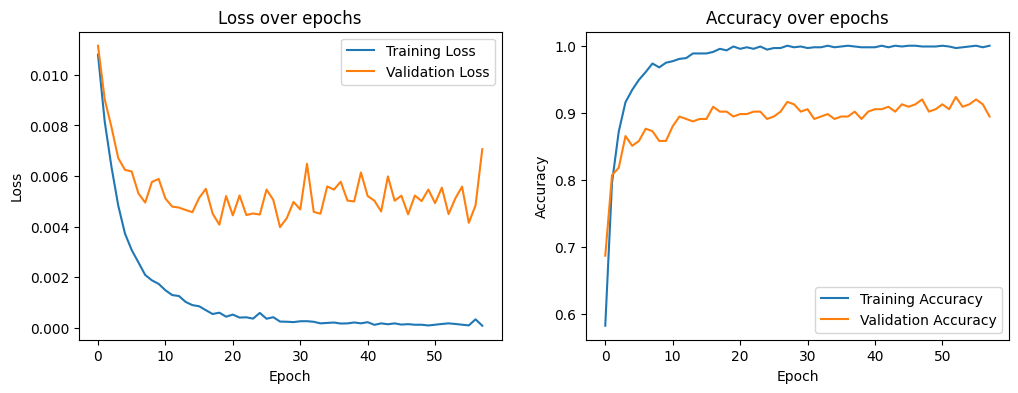

In [31]:
#plot_training_history(0, "cls_chkpoint_resnet18/checkpoint_2023-12-24-15-10_lr_0.0001_batch_64/history.json")
plot_training_history(history)

# Testing models

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


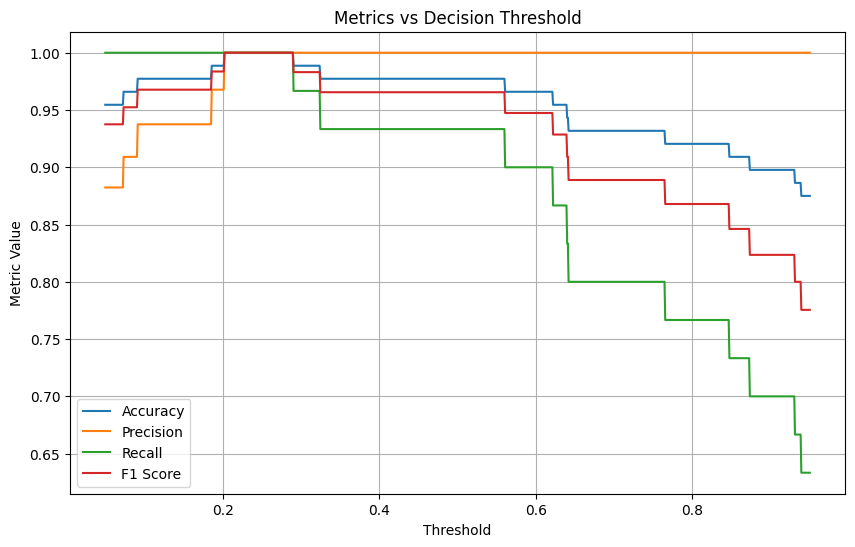

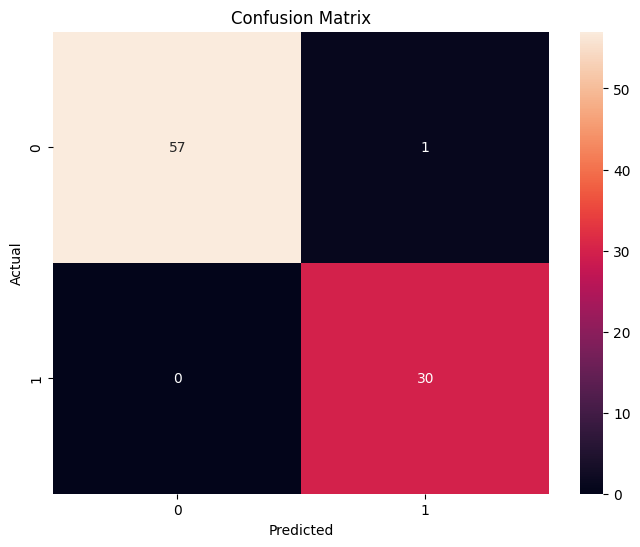

In [32]:
#model = load_resnet18("cls_chkpoint_resnet18/checkpoint_2024-01-01-22-28_lr_0.003_batch_128/checkpoint_2024-01-01-22-28_lr_0.003_batch_128/checkpoint_epoch_15.pth", 1)
all_probs, all_labels = plot_PR_curve(model, test_loader)
plot_confusion_matrix(all_probs, all_labels, threshold=0.2)

In [36]:
show_feature_map(model, 'data/classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg' )
Image.open('data/classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg')

NameError: name 'show_feature_map' is not defined

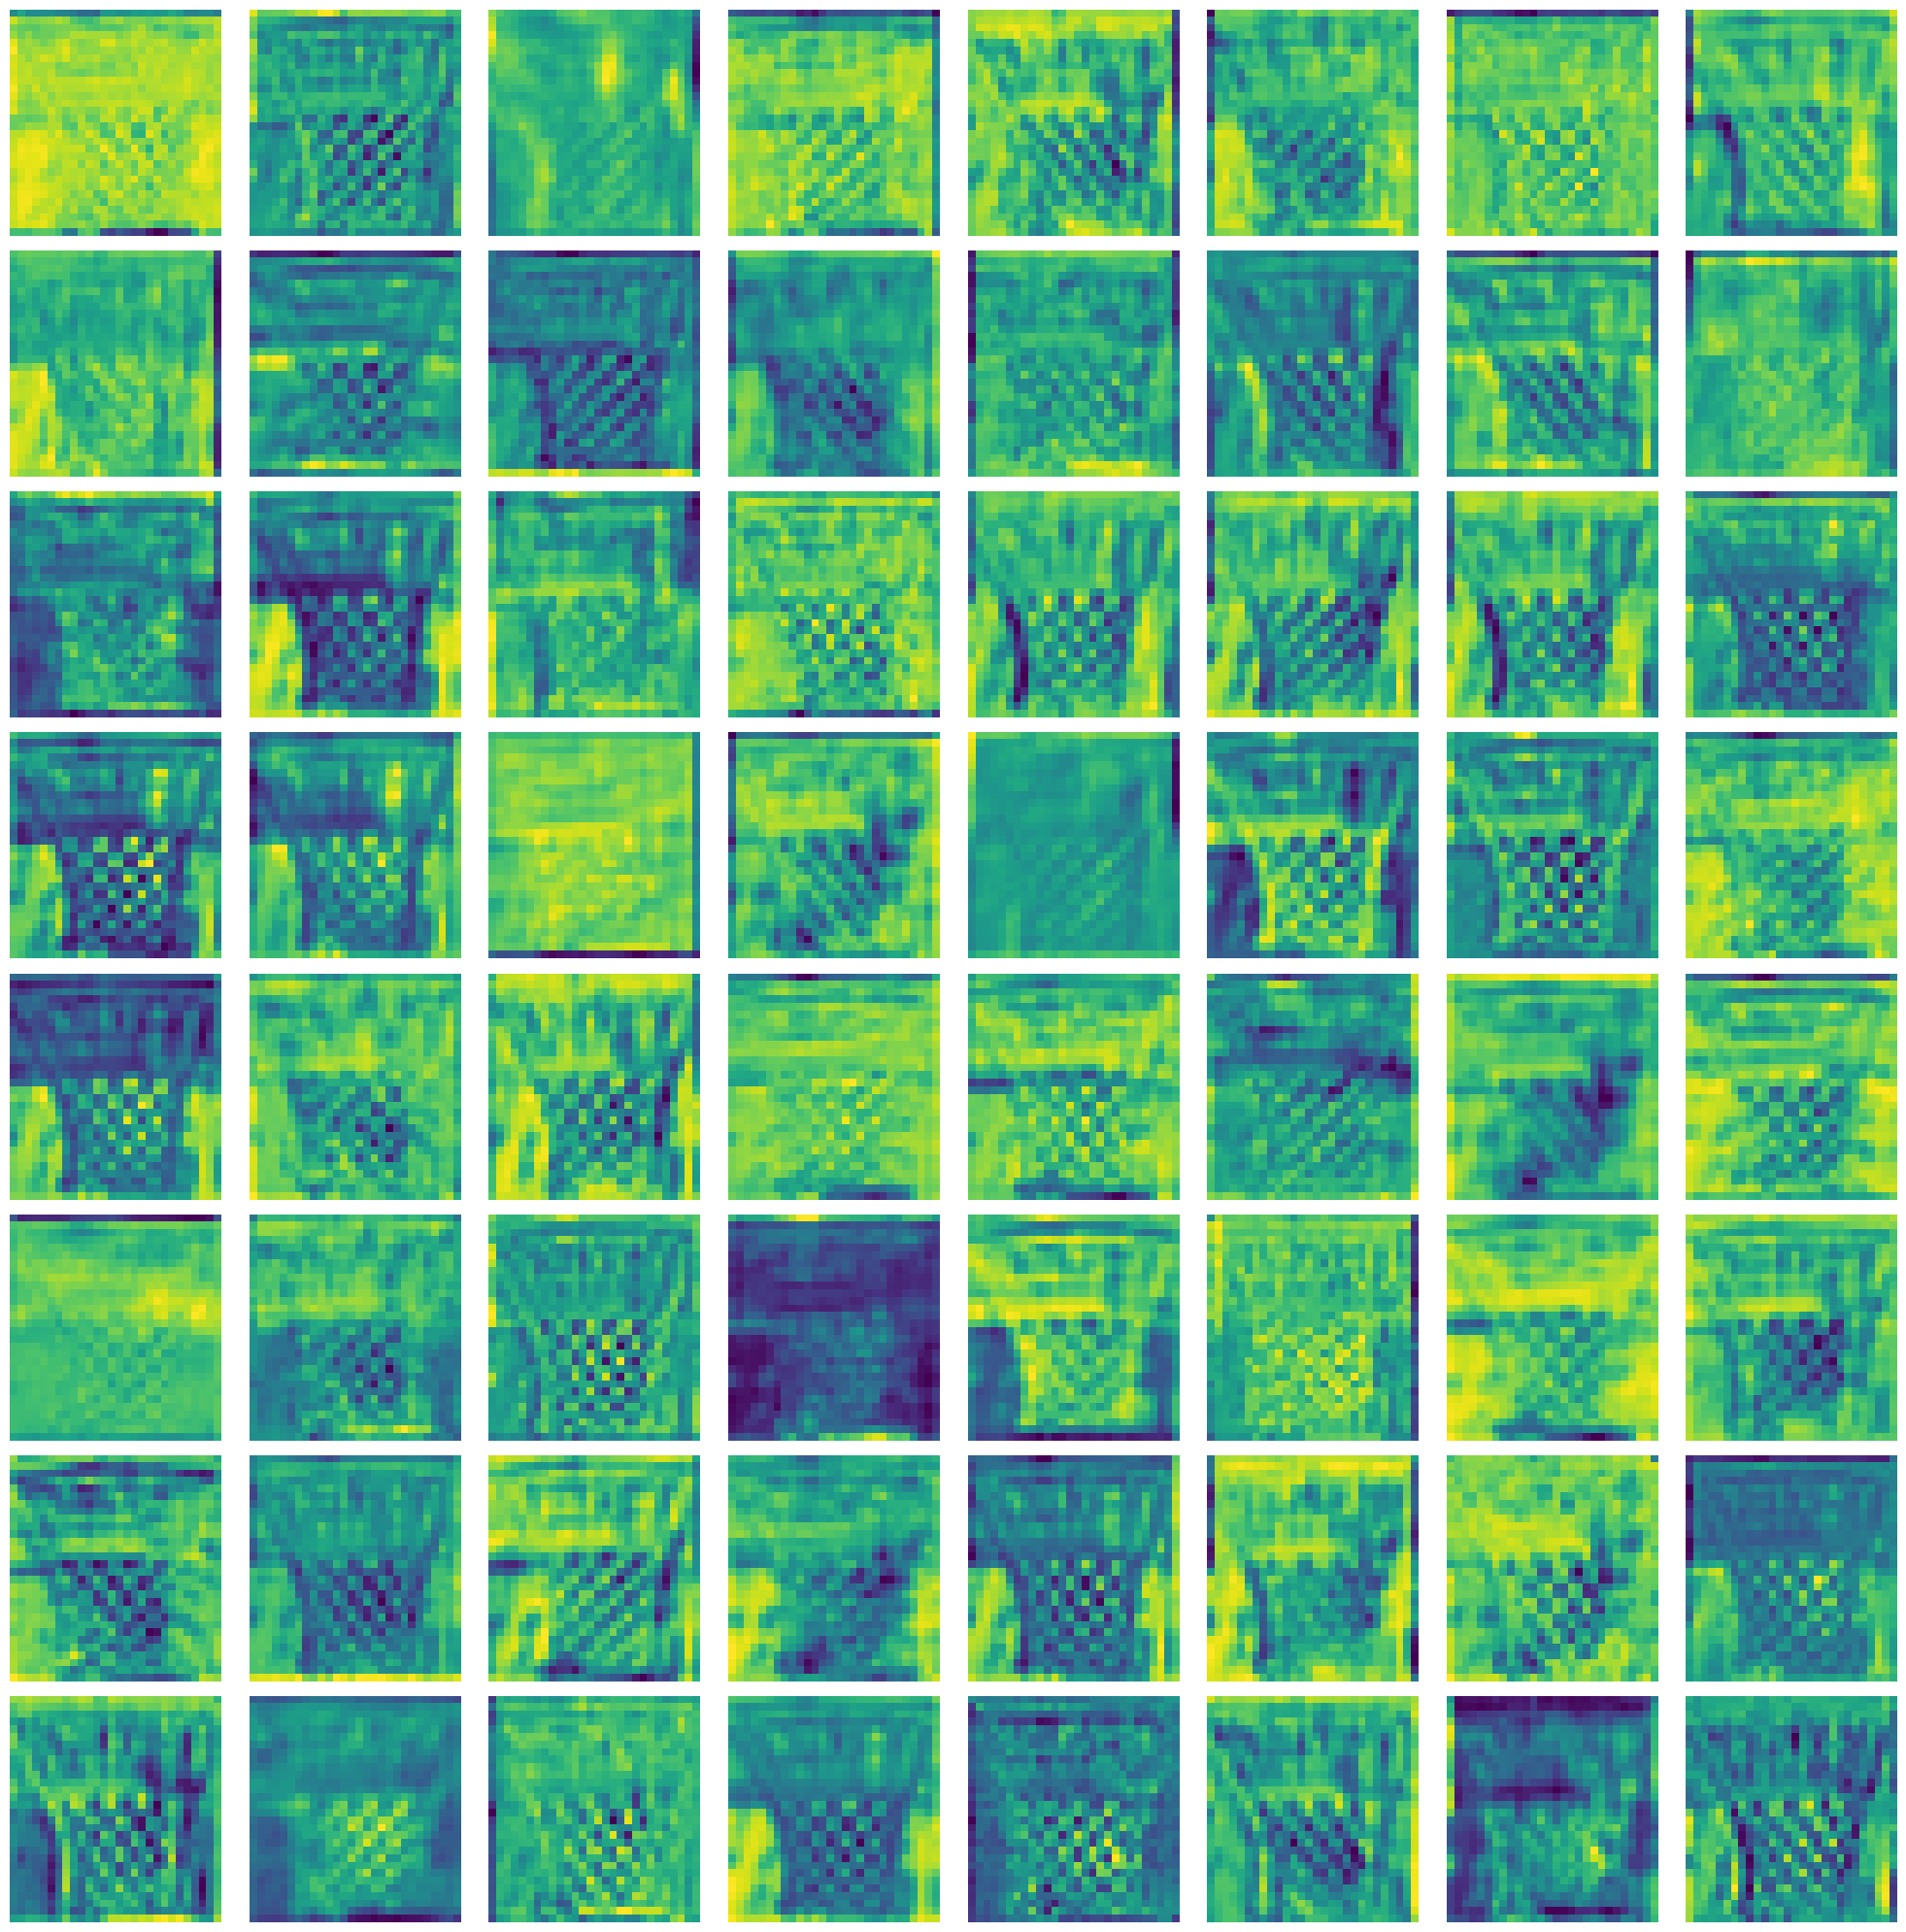

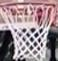

In [16]:
show_feature_map(model, "classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")
# display the image
Image.open("classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")

# Tuning Hyperparams


In [14]:
r.get_best_config(metric="accuracy", mode="max")

{'lr': 0.004922064284606748,
 'batch_size': 128,
 'optimizer': 'sgd',
 'img_size': 224,
 'nestrov': True,
 'momentum': 0.7510258908870537,
 'normalize': Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])}